In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture as GMM
from scipy.stats import multivariate_normal

In [2]:
data = pd.read_csv("data/gmm_filtered_embryo_data.csv")
data = data.loc[data.inlier == 1] 

In [37]:
cell_index= 100
chr_ = 19
cell = data.loc[data.cell_index==cell_index]
cell_chr = data.loc[(data.cell_index==cell_index)&(data.chr==chr_)]

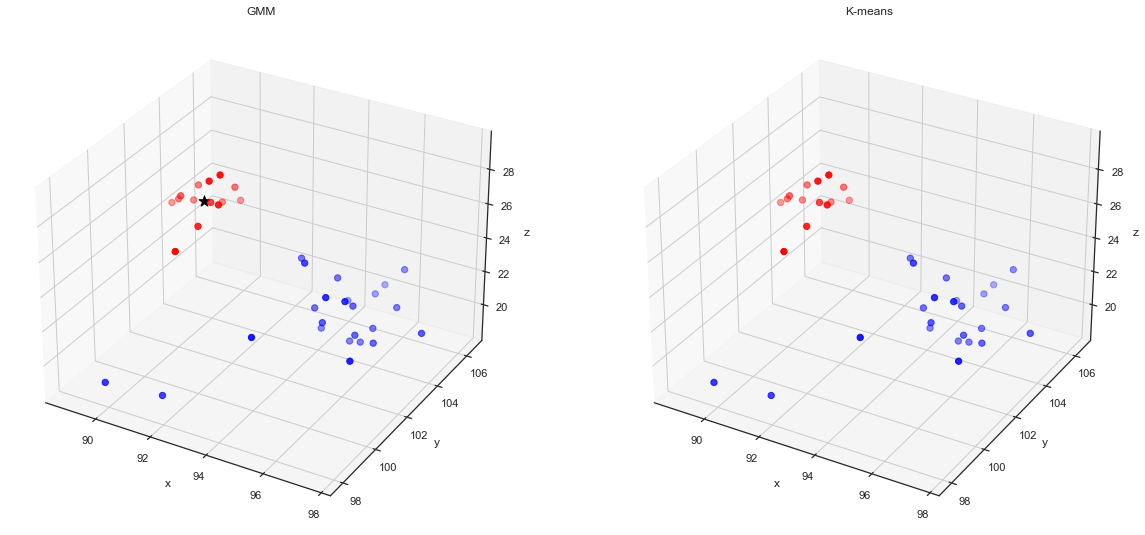

In [39]:
X=cell_chr[['x_um_abs','y_um_abs','z_um_abs']]
gmm = GMM(n_components=2, random_state = 0).fit(X)
labels = gmm.predict(X)
probs = gmm.predict_proba(X)
likelihood = np.exp(gmm.score_samples(X))
fig = plt.figure(figsize=(20,15))


ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], X.iloc[:, 2], c = cell_chr.cluster, s=40, cmap='bwr' )
ax.set_title("K-means")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


# X = X.iloc[np.where(labels==1)]
# labels = labels[np.where(labels==1)]


ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], X.iloc[:, 2], c=labels, s=40, cmap='bwr')
ax.scatter(gmm.means_[1,0], gmm.means_[1,1], gmm.means_[1,2], marker = "*", s = 130, color = 'black')
ax.set_title("GMM")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')




plt.show()

In [23]:
gmm.means_[1]

array([119.71196359, 148.21975903,  35.36714976])

In [43]:
# Z = np.append(X,Y, axis = 0)
# Z = np.append(Z, np.array([[20,12]]), axis = 0)
# Z = X

def get_p(x, mu, cov):
    cdf = multivariate_normal.cdf(x, mean=mu, cov=cov)
    return 2*np.minimum(cdf, 1-cdf)

"""
does GMM with two components on points. Returns: labels, probs, p
all are N dim vectors: 
labels is a vector of 0/1s, 
probs is the probabilty of a sample belonging to either cluster, 
p is the p-value of a sample belonging to its assigned cluster
"""
def do_gmm(Z: np.array): #Z is nx3
    gmm = GMM(n_components=2, random_state = 0).fit(Z)
    labels = gmm.predict(Z)
    probs = gmm.predict_proba(Z) # Nx2 gives the probability of a sample belonging to either of the models
    probs = np.max(probs, axis =1)
    likelihood = np.exp(gmm.score_samples(Z) ) #value of pdf for the GMM evaluated at each sample

    p = np.empty(labels.shape)  # this will hold the probability of each sample belonging to that gaussian (2*(1-cdf))
    p[:] = np.nan
    for label in np.unique(labels):
        ind = np.where(labels==label)
        p[ind] = get_p(Z[ind], gmm.means_[label], gmm.covariances_[label])
    
    return labels, probs, p 

In [73]:
##### running GMM on each chromosome on in each cell

data["gmm_cluster"] = np.nan
data["gmm_cluster_prob"] = np.nan #how confident we are in assigning the cluster: the probability a read is assigned to one cluster vs another
data["gmm_prob"] = np.nan # the likelihood (2*[1-cdf]) of a sample coming from the assigned gaussian
cell_ids = data.cell_index.unique()
for cell_id in cell_ids:
    cell = data.loc[data.cell_index == cell_id]
    chrs = cell.chr.unique()
    for chr_num in chrs:
        chr_ = cell.loc[cell.chr == chr_num]
        
        X=np.array(chr_[['x_um_abs','y_um_abs','z_um_abs']])
        print(cell_id, chr_num)
        cluster, cluster_prob, prob = do_gmm(X)
        data.loc[(data.cell_index == cell_id)&(data.chr==chr_num), "gmm_cluster"] = cluster
        data.loc[(data.cell_index == cell_id)&(data.chr==chr_num), "gmm_cluster_prob"] = cluster_prob
        data.loc[(data.cell_index == cell_id)&(data.chr==chr_num), "gmm_prob"] = prob
        
        
data.to_csv("data/gmm_filtered_embryo_data.csv", index = False)


1 9
1 14
1 3
1 5
1 8
1 7
1 10
1 2
1 15
1 4
1 1
1 13
1 6
1 17
1 12
1 18
1 16
1 11
1 20
1 19
1 27
1 21
2 1
2 3
2 9
2 10
2 5
2 12
2 18
2 14
2 6
2 4
2 2
2 11
2 7
2 13
2 17
2 16
2 8
2 15
2 20
2 19
3 2
3 17
3 7
3 3
3 11
3 9
3 16
3 5
3 15
3 8
3 12
3 19
3 10
3 14
3 13
3 20
3 1
3 6
3 4
3 18
4 16
4 2
4 6
4 11
4 7
4 8
4 14
4 3
4 20
4 12
4 4
4 10
4 1
4 13
4 19
4 9
4 18
4 17
4 5
4 15
5 4
5 10
5 12
5 9
5 15
5 1
5 20
5 18
5 2
5 16
5 5
5 17
5 7
5 14
5 11
5 8
5 3
5 6
5 13
5 19
6 16
6 6
6 14
6 2
6 1
6 18
6 3
6 17
6 15
6 4
6 10
6 8
6 13
6 20
6 5
6 7
6 9
6 19
6 11
6 12
6 27
7 13
7 17
7 7
7 4
7 5
7 15
7 11
7 18
7 9
7 16
7 10
7 3
7 20
7 14
7 6
7 19
7 12
7 8
7 1
7 2
7 27
8 11
8 17
8 3
8 10
8 8
8 12
8 15
8 14
8 16
8 18
8 5
8 19
8 7
8 20
8 9
8 13
8 1
8 4
8 2
8 6
8 27
9 2
9 7
9 12
9 11
9 6
9 19
9 9
9 3
9 13
9 5
9 16
9 14
9 4
9 17
9 1
9 18
9 8
9 10
9 15
9 20
10 10
10 5
10 18
10 2
10 3
10 15
10 11
10 13
10 16
10 6
10 20
10 9
10 4
10 14
10 1
10 17
10 19
10 7
10 8
10 12
10 27
11 16
11 4
11 5
11 1
11 3
11 7
11 20
11

75 5
75 11
75 12
75 8
75 18
75 16
75 9
75 2
75 17
75 19
75 20
76 1
76 8
76 7
76 20
76 9
76 14
76 6
76 4
76 2
76 15
76 5
76 13
76 17
76 10
77 20
77 11
77 2
77 14
77 3
77 6
77 9
77 1
77 18
77 5
77 16
77 12
77 19
77 10
77 13
77 8
77 7
77 15
77 4
77 17
77 27
78 2
78 1
78 3
78 12
78 5
78 13
78 10
78 16
78 19
78 11
78 20
78 17
78 14
78 8
78 6
78 4
78 9
78 7
78 15
78 18
79 11
79 17
79 3
79 18
79 9
79 20
79 14
79 1
79 15
79 4
79 12
79 7
79 13
79 16
79 5
79 6
79 8
79 2
79 10
79 19
79 27
81 20
81 13
81 9
81 12
81 3
81 10
81 16
81 7
81 5
81 4
81 11
81 14
81 1
81 6
81 8
81 18
81 2
81 15
81 17
82 8
82 18
82 10
82 1
82 6
82 19
82 2
82 9
82 11
82 13
82 5
82 4
82 14
82 12
82 7
82 17
82 3
82 15
82 16
83 2
83 8
83 13
83 3
83 4
83 1
83 20
83 7
83 9
83 5
83 16
83 15
83 17
83 14
83 10
83 12
83 18
83 6
83 11
85 8
85 3
85 9
85 17
85 5
85 4
85 11
85 10
85 2
85 16
85 6
85 14
85 15
85 19
85 18
85 7
85 13
85 1
85 20
85 12
85 27
86 2
86 20
86 19
86 11
86 16
86 9
86 4
86 1
86 18
86 10
86 6
86 12
86 14
86 5
86 7
86

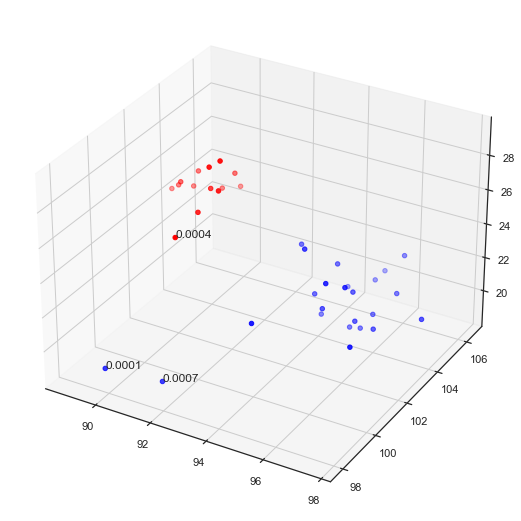

In [40]:
chr_ = data.loc[(data.cell_index==100)&(data.chr==19)]

fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(1, 2, 1, projection='3d')
# sns.set(rc = {'figure.figsize':(15,8)})
# sns.set_style("white")
ax.scatter(chr_.x_um_abs, chr_.y_um_abs, chr_.z_um_abs, c = chr_.gmm_cluster, cmap = 'bwr')
for i in range(chr_.shape[0]):
    if chr_.iloc[i].loc['gmm_prob'] < 1e-3:
        ax.text(chr_.iloc[i].loc['x_um_abs'], 
                 chr_.iloc[i].loc['y_um_abs'],
                 chr_.iloc[i].loc['z_um_abs'],
                 str(np.round(chr_.iloc[i].loc['gmm_prob'],4))) 
        
        
        #  

In [68]:
chr_.gmm_cluster_prob[0]

1.0

(-20.0, 20.0)

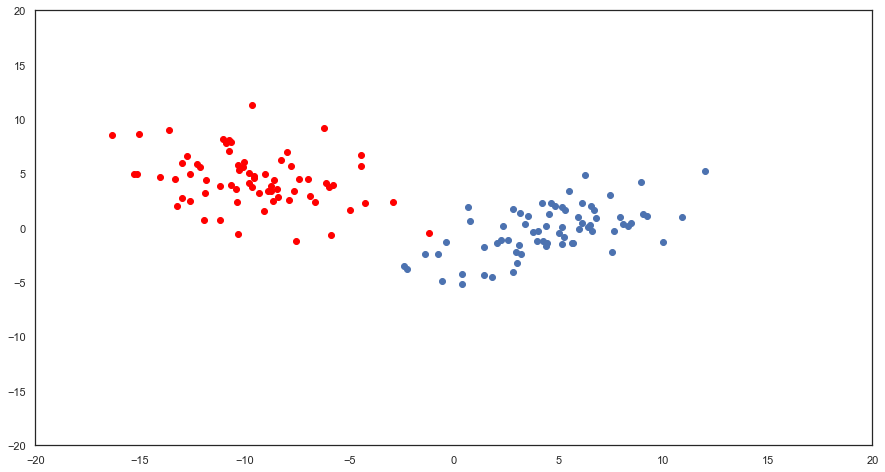

In [65]:
X = np.random.multivariate_normal([5,0], [[10,4],[4,5]], (70))
Y = np.random.multivariate_normal([-9,5], [[9,-4],[-4,8]], (70))
plt.scatter(X[:,0], X[:,1])
plt.scatter(Y[:,0], Y[:,1], color = 'red')
plt.xlim(-20,20)
plt.ylim(-20,20)

/home/parmida/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/parmida/anaconda3/lib/python3.9/site-packages/seaborn/relational.py:654: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  kws["alpha"] = 1 if self.alpha == "auto" else self.alpha


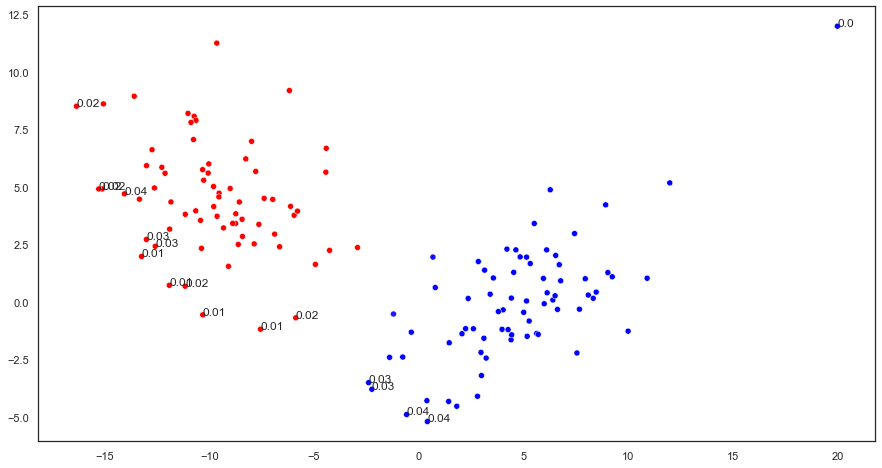

In [94]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_style("white")
sns.scatterplot(Z[:,0], Z[:,1], c = labels, cmap = 'bwr', alpha = np.max(probs, axis =1)**2) 
for i in range(Z.shape[0]):
    if p[i] < 0.05:
        plt.text(Z[i,0], Z[i,1],str(np.round(p[i],2)))  #  